In [136]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Dense, Activation,MaxPooling1D, GlobalAveragePooling1D, Dropout, Lambda, RepeatVector, Input, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math


In [137]:
print(tensorflow.__version__)

2.2.0


In [236]:
def buildYTrain(train, pastDay, futureDay,profit):
    Y_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        ave = np.mean(train['high'][i+pastDay+1:i+pastDay+futureDay])
        if (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] > profit:
            Y_train.append(0)
        #elif (ave-train['close'][i+pastDay])/ train['close'][i+pastDay] < -profit:
        #    Y_train.append(1)
        else:
            Y_train.append(1)     
    return np.array(Y_train)

def buildXTrain(train, pastDay, futureDay,profit):
    X_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
    return np.array(X_train)

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [237]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
    print(df.tail())
    print(df.shape)
    #df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)
    df = df[['open','high','low','close','volume']]
    df['diff1'] = df['close']-df['open']
    df['diff2']= df['close']-df['low']
    df['diff3']= df['high']-df['close']
    df['diff4']= df['high']-df['low']
    df['diff5']= df['open']-df['low']
    df['diff5']= df['high']-df['open']


    

      adj_close  close   high    low   open    volume  year  month  day  week  \
4102      458.0  458.5  460.0  454.0  458.0  43415670  2020     11    9     0   
4103      451.0  451.0  454.5  448.5  452.0  36786882  2020     11   10     1   
4104      456.5  457.0  457.0  448.5  448.5  40355804  2020     11   11     2   
4105      457.5  458.0  463.5  457.5  463.0  57993774  2020     11   12     3   
4106      461.5  462.0  462.0  456.5  459.0  31483881  2020     11   13     4   

      ...       DEM       OSC  Dif  cal_U  cal_D     ema_U     ema_D  \
4102  ...  1.889218  0.436539  6.0    6.0    0.0  2.976283  1.354608   
4103  ...  1.985602  0.385533 -7.5    0.0    7.5  2.579445  2.173993   
4104  ...  2.160141  0.698157  6.0    6.0    0.0  3.035519  1.884128   
4105  ...  2.385548  0.901629  1.0    1.0    0.0  2.764117  1.632911   
4106  ...  2.689403  1.215419  4.0    4.0    0.0  2.928901  1.415189   

            RS        RSI       OBV  
4102  2.197155  68.722188  0.750000  
4103

In [238]:
past = 60
future = 5
profit = 0.01
val_ratio = 0.2
num_classes=2
data_y = buildYTrain(df.copy().iloc[:-100],past,future,profit)

data = normalize_data(df.copy().iloc[:-100])

data_x = buildXTrain(data,past,future,profit)


In [239]:
print(data_y.shape)
print(data_x.shape)
more=0
less=0
equal=0
for i in range(data_y.shape[0]):
    if data_y[i]==0:
        more+=1
    elif data_y[i]==1:
        less+=1
    else:
        equal+=1
print(more,less,equal)
    

(3942,)
(3942, 60, 10)
1810 2132 0


In [240]:
data_X, data_Y = shuffle(data_x, data_y)
x_train, y_train, x_val, y_val = splitData(data_X, data_Y, val_ratio)
Y_train = to_categorical(y_train, num_classes=num_classes)
Y_val = to_categorical(y_val, num_classes=num_classes)

In [241]:
print(Y_val.shape)
x_train.shape[1:]

(788, 2)


(60, 10)

In [242]:
backend.clear_session()

model = Sequential()
model.add(Conv1D(64, 1, activation='selu', input_shape=(x_train.shape[1:])))
model.add(MaxPooling1D(2))
#model.add(Conv1D(300, 5, activation='selu'))
model.add(Conv1D(128, 3, activation='selu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='selu'))

#model.add(Conv1D(160, 3, activation='selu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(200, activation='selu'))
#model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(2, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60, 64)            704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 128)           49280     
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               3

Epoch 1/1000
25/25 [==============================] - 1s 21ms/step - loss: 1.0118 - accuracy: 0.5105 - val_loss: 0.7073 - val_accuracy: 0.4581
Epoch 2/1000
25/25 [==============================] - 0s 18ms/step - loss: 0.7048 - accuracy: 0.5133 - val_loss: 0.6891 - val_accuracy: 0.5419
Epoch 3/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.6903 - accuracy: 0.5450 - val_loss: 0.7077 - val_accuracy: 0.4543
Epoch 4/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.6911 - accuracy: 0.5368 - val_loss: 0.6856 - val_accuracy: 0.5444
Epoch 5/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.6844 - accuracy: 0.5444 - val_loss: 0.6915 - val_accuracy: 0.5140
Epoch 6/1000
25/25 [==============================] - 0s 17ms/step - loss: 0.6789 - accuracy: 0.5726 - val_loss: 0.6827 - val_accuracy: 0.5685
Epoch 7/1000
25/25 [==============================] - 0s 16ms/step - loss: 0.6755 - accuracy: 0.5701 - val_loss: 0.6850 - val_accuracy: 0.5431

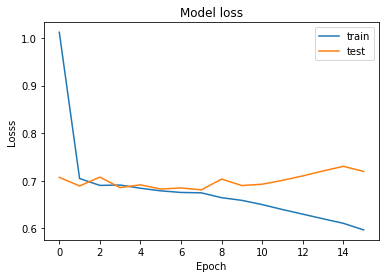

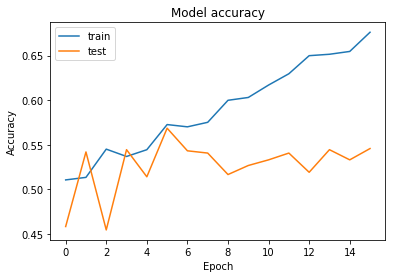

In [243]:
callback = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="auto")
history=model.fit(x_train, Y_train, epochs=1000, batch_size=128, validation_data=(x_val, Y_val), callbacks=[callback])
training_result(history)

In [211]:
ans=model.predict(x_train)

In [213]:
ans[-20:]

array([[0.203464  , 0.11209084, 0.6844452 ],
       [0.02703418, 0.03112623, 0.9418396 ],
       [0.12180689, 0.00601981, 0.8721733 ],
       [0.54148114, 0.0608865 , 0.3976324 ],
       [0.27006513, 0.21015279, 0.51978207],
       [0.77789724, 0.0569267 , 0.16517608],
       [0.3873342 , 0.33669227, 0.2759736 ],
       [0.5657544 , 0.08887959, 0.34536594],
       [0.38235247, 0.02151475, 0.59613276],
       [0.56467986, 0.03737861, 0.39794153],
       [0.31568894, 0.04495285, 0.63935816],
       [0.7568704 , 0.01209757, 0.23103206],
       [0.4483746 , 0.04724453, 0.5043809 ],
       [0.16561371, 0.08105234, 0.753334  ],
       [0.47480652, 0.06976324, 0.45543027],
       [0.29144034, 0.16836447, 0.54019517],
       [0.5450649 , 0.03306562, 0.42186952],
       [0.33618835, 0.01650424, 0.6473074 ],
       [0.02727505, 0.05940446, 0.91332054],
       [0.66950274, 0.02974115, 0.30075613]], dtype=float32)